# Importing the Libraries

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
!pip install emoji

   ---------------------------------------- 0.0/586.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/586.9 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/586.9 kB ? eta -:--:--
   -------------------------------------- 586.9/586.9 kB 902.1 kB/s eta 0:00:00


In [6]:
import os
import re
import string
import emoji
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [9]:
train_data = pd.read_csv("../datasets/CREMA-D/goemtions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
valid_data = pd.read_csv("../datasets/CREMA-D/goemtions/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
test_data = pd.read_csv("../datasets/CREMA-D/goemtions/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [10]:
train_data.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    43410 non-null  object
 1   Class   43410 non-null  object
 2   ID      43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


# Data Preparation

Converting our data to be of format Text -> Labels (one hot type) with Ekman Taxonomy

In [12]:
train_data['Class List'] = train_data['Class'].apply(lambda x: x.split(','))
train_data['Class Length'] = train_data['Class List'].apply(lambda x: len(x))

valid_data['Class List'] = valid_data['Class'].apply(lambda x: x.split(','))
valid_data['Class Length'] = valid_data['Class List'].apply(lambda x: len(x))

test_data['Class List'] = test_data['Class'].apply(lambda x: x.split(','))
test_data['Class Length'] = test_data['Class List'].apply(lambda x: len(x))

In [13]:
train_data.head()

,Text,Class,ID,Class List,Class Length
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1
3,To make her feel threatened,14,ed7ypvh,[14],1
4,Dirty Southern Wankers,3,ed0bdzj,[3],1


In [14]:
train_data["Class Length"].value_counts()

Class Length
1    36308
2     6541
3      532
4       28
5        1
Name: count, dtype: int64

In [16]:
with open('../datasets/CREMA-D/goemtions/data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [17]:
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [19]:
emotion_file = open("../datasets/CREMA-D/goemtions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [20]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [21]:
train_data['Emotions'] = train_data['Class List'].apply(idx2class)
valid_data['Emotions'] = valid_data['Class List'].apply(idx2class)
test_data['Emotions'] = test_data['Class List'].apply(idx2class)

In [22]:
train_data["Emotions"].value_counts()

Emotions
[neutral]                                        12823
[admiration]                                      2710
[approval]                                        1873
[gratitude]                                       1857
[amusement]                                       1652
                                                 ...  
[confusion, gratitude, realization]                  1
[disappointment, disapproval, nervousness]           1
[curiosity, disapproval, sadness]                    1
[curiosity, disappointment, remorse, sadness]        1
[admiration, amusement, love]                        1
Name: count, Length: 711, dtype: int64

In [23]:
train_data.head()

,Text,Class,ID,Class List,Class Length,Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [24]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [25]:
train_data['Mapped Emotions'] = train_data['Emotions'].apply(EmotionMapping)
valid_data['Mapped Emotions'] = valid_data['Emotions'].apply(EmotionMapping)
test_data['Mapped Emotions'] = test_data['Emotions'].apply(EmotionMapping)

In [26]:
train_data["Mapped Emotions"].value_counts()

Mapped Emotions
[joy]                       12920
[neutral]                   12823
[anger]                      3878
[surprise]                   3553
[joy, joy]                   2129
                            ...  
[fear, sadness, sadness]        1
[joy, anger, disgust]           1
[joy, fear, surprise]           1
[disgust, fear, joy]            1
[joy, anger, joy, joy]          1
Name: count, Length: 166, dtype: int64

In [27]:
train_data['anger'] = np.zeros((len(train_data),1))
train_data['disgust'] = np.zeros((len(train_data),1))
train_data['fear'] = np.zeros((len(train_data),1))
train_data['joy'] = np.zeros((len(train_data),1))
train_data['sadness'] = np.zeros((len(train_data),1))
train_data['surprise'] = np.zeros((len(train_data),1))
train_data['neutral'] = np.zeros((len(train_data),1))

valid_data['anger'] = np.zeros((len(valid_data),1))
valid_data['disgust'] = np.zeros((len(valid_data),1))
valid_data['fear'] = np.zeros((len(valid_data),1))
valid_data['joy'] = np.zeros((len(valid_data),1))
valid_data['sadness'] = np.zeros((len(valid_data),1))
valid_data['surprise'] = np.zeros((len(valid_data),1))
valid_data['neutral'] = np.zeros((len(valid_data),1))

test_data['anger'] = np.zeros((len(test_data),1))
test_data['disgust'] = np.zeros((len(test_data),1))
test_data['fear'] = np.zeros((len(test_data),1))
test_data['joy'] = np.zeros((len(test_data),1))
test_data['sadness'] = np.zeros((len(test_data),1))
test_data['surprise'] = np.zeros((len(test_data),1))
test_data['neutral'] = np.zeros((len(test_data),1))

In [28]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    train_data[i] = train_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    valid_data[i] = valid_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    test_data[i] = test_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [29]:
train_data.head()

,Text,Class,ID,Class List,Class Length,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [30]:
train_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
valid_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
test_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)

# Data PreProcessing

In [31]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = preprocess(text)
    return text

In [32]:
train_data['Text'] = train_data['Text'].apply(lambda x: preprocess(x))

In [33]:
valid_data["Text"] = valid_data["Text"].apply(lambda x: preprocess(x))

In [34]:
test_data["Text"] = test_data["Text"].apply(text_preprocessing_pipeline)

In [35]:
pd.Series(train_data["Text"]).str.split().str.len().describe(percentiles=[0.05, 0.97])

count    43410.000000
mean         7.761253
std          3.956936
min          0.000000
5%           2.000000
50%          7.000000
97%         16.000000
max         33.000000
Name: Text, dtype: float64

In [36]:
train_data.head()

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1
1,now everyone think he laugh screwing people in...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0
3,to make feel threatened,0,0,1,0,0,0,0
4,dirty southern wanker,1,0,0,0,0,0,0


In [37]:
for col in train_data.columns[1:]:
    print(f"{col}:\n",train_data[col].value_counts())
    print("\n")

anger:
 anger
0    37831
1     5579
Name: count, dtype: int64


disgust:
 disgust
0    42617
1      793
Name: count, dtype: int64


fear:
 fear
0    42684
1      726
Name: count, dtype: int64


joy:
 joy
0    26000
1    17410
Name: count, dtype: int64


sadness:
 sadness
0    40147
1     3263
Name: count, dtype: int64


surprise:
 surprise
0    38043
1     5367
Name: count, dtype: int64


neutral:
 neutral
0    29191
1    14219
Name: count, dtype: int64




# Model_1 (Baseline RoBERTa with Freezed Layers)

In [38]:
train_labels = train_data.drop("Text", axis=1)
valid_labels = valid_data.drop("Text", axis=1)
test_labels = test_data.drop("Text", axis=1)

In [39]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [40]:
def roberta_encode(data, maximum_length, tokenizer) :
    
    
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for i in range(len(data['Text'])):
        
        encoded = tokenizer.encode_plus(data["Text"].iloc[i],
                                        add_special_tokens=True,
                                        max_length=maximum_length,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        truncation=True,
                                        return_token_type_ids=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        token_type_ids.append(encoded["token_type_ids"])
        
        
    return np.array(input_ids),np.array(attention_masks),np.array(token_type_ids)

In [41]:
len(train_data.Text)

43410

In [42]:
max_len = max([len(x.split()) for x in train_data['Text']])
train_input_ids,train_attention_masks, train_token_type_ids = roberta_encode(train_data, max_len, tokenizer)
valid_input_ids,valid_attention_masks, valid_token_type_ids = roberta_encode(valid_data, max_len, tokenizer)
test_input_ids,test_attention_masks, test_token_type_ids = roberta_encode(test_data, max_len, tokenizer)

In [43]:
train_input_ids[0], train_attention_masks[0], train_token_type_ids[0]

(array([   0, 4783, 5548,  689,  932,  939, 7142,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [44]:
train_labels.shape, valid_labels.shape, test_labels.shape

((43410, 7), (5426, 7), (5427, 7))

In [45]:
train_input_ids.shape, valid_input_ids.shape, test_input_ids.shape

((43410, 33), (5426, 33), (5427, 33))

In [46]:
train_attention_masks.shape, valid_attention_masks.shape, test_attention_masks.shape

((43410, 33), (5426, 33), (5427, 33))

In [47]:
train_token_type_ids.shape, valid_token_type_ids.shape, test_token_type_ids.shape

((43410, 33), (5426, 33), (5427, 33))

In [48]:
train_data.head(1)

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1


In [49]:
def create_model(bert_model, max_len, num_classes=7):
    
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    token_type_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    features = bert_model([input_ids,attention_masks, token_type_ids])
    fc_1 = tf.keras.layers.Dense(256, activation="relu")(features[1])
    dropout_1 = tf.keras.layers.Dropout(0.7)(fc_1)
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dropout_1)
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_masks,token_type_ids], outputs=output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])
    return model

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [51]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [52]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]',            

In [57]:
from transformers import RobertaTokenizer

# Load tokenizer from the base RoBERTa model
base_model = "roberta-base"  # Or any model you fine-tuned from
tokenizer = RobertaTokenizer.from_pretrained(base_model)

# Save tokenizer files to your directory
tokenizer.save_pretrained("C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion")


('C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion\\tokenizer_config.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion\\special_tokens_map.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion\\vocab.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion\\merges.txt',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion\\added_tokens.json')

In [58]:
model_path = "C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion"


In [59]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AutoConfig

model_path = "C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/best-fine_tuned_roberta_emotion"

# Load the configuration
config = AutoConfig.from_pretrained(model_path)

# Load the pre-trained model
model = RobertaForSequenceClassification.from_pretrained(model_path, config=config)

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_path)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
text = "This is a test for the emotion recognition model."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

outputs = model(**inputs)
logits = outputs.logits
print(logits)


tensor([[ 4.7852,  0.3318, -0.7080, -0.6150, -1.3311, -1.2165, -1.3716]],
       grad_fn=<AddmmBackward0>)


In [65]:
from transformers import RobertaTokenizer

# Download and save tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer.save_pretrained("C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model")


('C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model\\tokenizer_config.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model\\special_tokens_map.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model\\vocab.json',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model\\merges.txt',
 'C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model\\added_tokens.json')

In [77]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Define paths
model_path = "C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = TFRobertaForSequenceClassification.from_pretrained(model_path)

print("Model and tokenizer loaded successfully!")

# Example data (replace with your actual data)
train_texts = ["Sample text 1", "Sample text 2", "Sample text 3"]
train_labels = [0, 1, 0]  # Replace with actual labels

valid_texts = ["Validation text 1", "Validation text 2"]
valid_labels = [0, 1]  # Replace with actual labels

# Tokenize the data
def tokenize_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]},
        labels
    ))
    return dataset

train_dataset = tokenize_data(train_texts, train_labels, tokenizer).batch(16)
valid_dataset = tokenize_data(valid_texts, valid_labels, tokenizer).batch(16)

# Compile the model
with tf.device('/GPU:0'):  # Use GPU if available
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

# Save the fine-tuned model
model.save_pretrained("C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model_updated")
tokenizer.save_pretrained("C:/Users/dell/Desktop/gradproject/AI04-Grad/multimodel/fine_tuned_roberta_emotion_model_updated")
print("Model fine-tuning complete and saved!")


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model and tokenizer loaded successfully!
Epoch 1/5


AttributeError: in user code:

    File "c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\transformers\modeling_tf_utils.py", line 1630, in train_step
        x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)

    AttributeError: module 'keras.utils' has no attribute 'unpack_x_y_sample_weight'


In [61]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

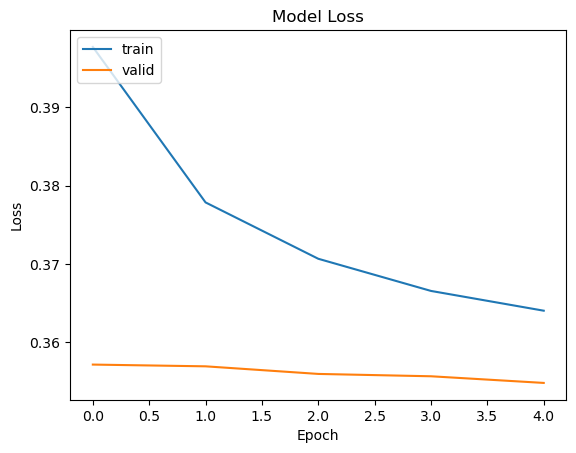

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

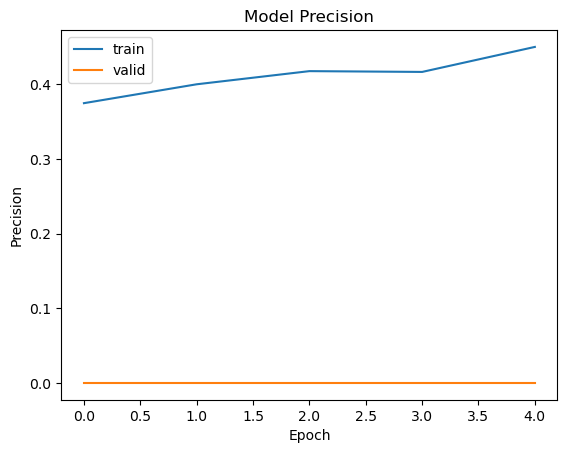

In [59]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [60]:
pred_labels = model.predict([test_input_ids,test_attention_masks, test_token_type_ids])

170/170 [==============================] - 17s 81ms/step


In [61]:
model.evaluate([test_input_ids,test_attention_masks, test_token_type_ids], test_labels)

170/170 [==============================] - 14s 82ms/step - loss: 0.3584 - accuracy: 0.3785 - precision: 0.0000e+00


[0.3583530783653259, 0.3784779906272888, 0.0]

In [62]:
pred_labels[:5]

array([[0.13159665, 0.01973769, 0.0176015 , 0.4215047 , 0.07655225,
        0.13015845, 0.3128461 ],
       [0.13340227, 0.01882755, 0.01661362, 0.3960007 , 0.07280622,
        0.12990455, 0.3237582 ],
       [0.12393906, 0.01703671, 0.01507586, 0.41056064, 0.0672873 ,
        0.12412437, 0.31853557],
       [0.12512106, 0.01772231, 0.01570323, 0.41187838, 0.07208394,
        0.12710157, 0.31864882],
       [0.12879835, 0.01798301, 0.01622118, 0.398354  , 0.07100627,
        0.12919076, 0.32303888]], dtype=float32)

In [63]:
def prob(x):
    if x>0.5:
        return 1
    return 0

In [64]:
pred_labels = [list(map(prob,i)) for i in pred_labels]

In [65]:
from sklearn.metrics import label_ranking_average_precision_score
lrap = label_ranking_average_precision_score(pred_labels, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  1.0


In [66]:
from sklearn.metrics import classification_report
target_names = train_data.columns[1:]
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       726
     disgust       0.00      0.00      0.00       123
        fear       0.00      0.00      0.00        98
         joy       0.00      0.00      0.00      2104
     sadness       0.00      0.00      0.00       379
    surprise       0.00      0.00      0.00       677
     neutral       0.00      0.00      0.00      1787

   micro avg       0.00      0.00      0.00      5894
   macro avg       0.00      0.00      0.00      5894
weighted avg       0.00      0.00      0.00      5894
 samples avg       0.00      0.00      0.00      5894



# Model_2 (RoBERTa with Unfreezed Layers)

In [67]:
es_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [68]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [69]:
model_2 = create_model(roberta_model, max_len)
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_10[0][0]',               
 odel)                          thPoolingAndCrossAt               'input_11[0][0]',         

In [70]:
history_2 = model_2.fit([train_input_ids,train_attention_masks,train_token_type_ids], train_labels,
                    validation_data=([valid_input_ids,valid_attention_masks,valid_token_type_ids], valid_labels),
                    epochs=5,
                    batch_size=16,
                    callbacks=[es_2])

Epoch 1/5
2714/2714 [==============================] - 458s 151ms/step - loss: 0.3417 - accuracy: 0.4993 - precision: 0.6355 - val_loss: 0.2867 - val_accuracy: 0.5722 - val_precision: 0.7409
Epoch 2/5
2714/2714 [==============================] - 392s 144ms/step - loss: 0.3040 - accuracy: 0.5744 - precision: 0.7074 - val_loss: 0.2735 - val_accuracy: 0.5934 - val_precision: 0.7511
Epoch 3/5
2714/2714 [==============================] - 391s 144ms/step - loss: 0.3189 - accuracy: 0.5294 - precision: 0.7077 - val_loss: 0.2996 - val_accuracy: 0.5728 - val_precision: 0.8392
Epoch 4/5
2714/2714 [==============================] - 392s 144ms/step - loss: 0.3045 - accuracy: 0.5742 - precision: 0.7122 - val_loss: 0.2852 - val_accuracy: 0.5826 - val_precision: 0.7117
Epoch 4: early stopping


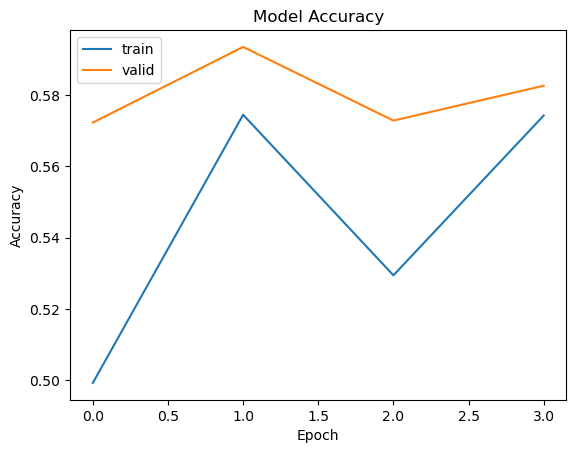

In [71]:
# summarize history for accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

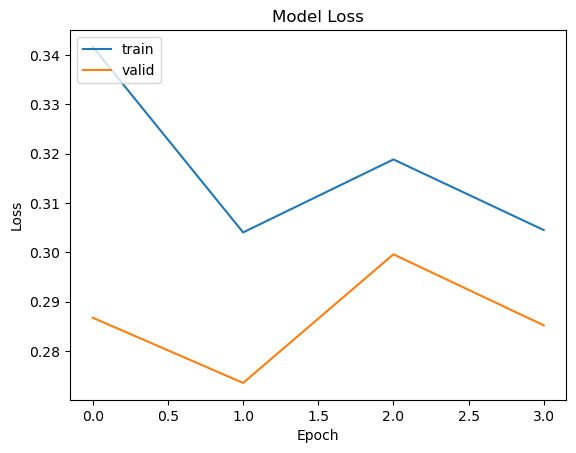

In [72]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

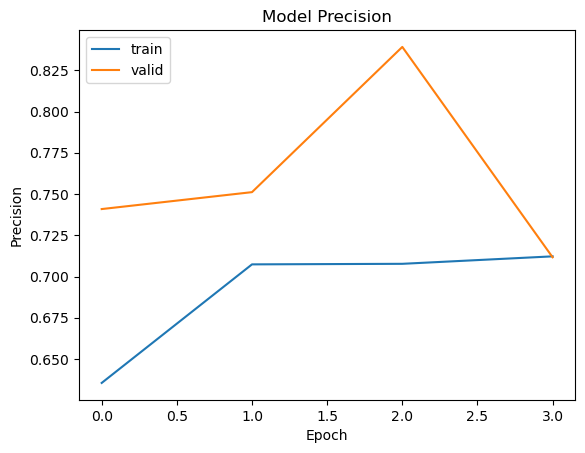

In [73]:
plt.plot(history_2.history['precision'])
plt.plot(history_2.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [74]:
pred_labels_2 = model_2.predict([test_input_ids,test_attention_masks, test_token_type_ids])

170/170 [==============================] - 16s 79ms/step


In [75]:
pred_labels_2[:5]

array([[1.72326624e-01, 8.65511671e-02, 9.22327191e-02, 1.22329906e-01,
        4.87401515e-01, 6.46626577e-02, 1.01856992e-01],
       [1.75258338e-01, 8.68608579e-02, 9.23543051e-02, 1.21721536e-01,
        4.83334899e-01, 6.53022155e-02, 1.03054732e-01],
       [6.82920218e-03, 2.08591126e-04, 2.97423230e-05, 9.68022406e-01,
        2.60201818e-03, 2.09089722e-02, 2.88523696e-02],
       [4.40404378e-03, 8.48675118e-05, 1.00685438e-05, 9.83035564e-01,
        1.42716279e-03, 1.32825775e-02, 1.60889123e-02],
       [3.31375152e-01, 1.48474937e-02, 1.47519661e-02, 1.15493514e-01,
        4.35542539e-02, 1.48706481e-01, 3.90042543e-01]], dtype=float32)

In [76]:
model_2.evaluate([test_input_ids,test_attention_masks, test_token_type_ids], test_labels)

170/170 [==============================] - 14s 82ms/step - loss: 0.2887 - accuracy: 0.5766 - precision: 0.7059


[0.2886902987957001, 0.5765616297721863, 0.7058982253074646]

In [77]:
pred_labels_2 = [list(map(prob,i)) for i in pred_labels_2]

In [78]:
lrap = label_ranking_average_precision_score(pred_labels_2, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  0.8068300472944056


In [79]:
print(classification_report(test_labels, pred_labels_2, target_names=train_data.columns[1:]))

              precision    recall  f1-score   support

       anger       0.47      0.06      0.11       726
     disgust       0.00      0.00      0.00       123
        fear       0.00      0.00      0.00        98
         joy       0.86      0.69      0.76      2104
     sadness       0.38      0.03      0.06       379
    surprise       0.00      0.00      0.00       677
     neutral       0.59      0.62      0.61      1787

   micro avg       0.71      0.44      0.55      5894
   macro avg       0.33      0.20      0.22      5894
weighted avg       0.57      0.44      0.47      5894
 samples avg       0.48      0.46      0.47      5894



# Model_3 (Dropping Neutral and disgust)

In [80]:
train_data.head()

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1
1,now everyone think he laugh screwing people in...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0
3,to make feel threatened,0,0,1,0,0,0,0
4,dirty southern wanker,1,0,0,0,0,0,0


In [81]:
train_data_new = train_data.drop(train_data[train_data['neutral'] == 1].index)
valid_data_new = valid_data.drop(valid_data[valid_data['neutral'] == 1].index)
test_data_new = test_data.drop(test_data[test_data['neutral'] == 1].index)

train_data_new = train_data_new.drop(train_data_new[train_data_new['disgust'] == 1].index)
valid_data_new = valid_data_new.drop(valid_data_new[valid_data_new['disgust'] == 1].index)
test_data_new = test_data_new.drop(test_data_new[test_data_new['disgust'] == 1].index)

train_data_new = train_data_new.drop(['neutral', 'disgust'], axis=1)
valid_data_new = valid_data_new.drop(['neutral', 'disgust'], axis=1)
test_data_new = test_data_new.drop(['neutral', 'disgust'], axis=1)

In [82]:
train_data_new.head()

,Text,anger,fear,joy,sadness,surprise
2,why the fuck is bayless isoing,1,0,0,0,0
3,to make feel threatened,0,1,0,0,0
4,dirty southern wanker,1,0,0,0,0
5,omg peyton isn t good enough to help u in the ...,0,0,0,0,1
6,yes i heard about f bomb that thanks reply hub...,0,0,1,0,0


In [83]:
train_data_new.shape

(28427, 6)

In [84]:
train_labels = train_data_new.drop("Text", axis=1)
valid_labels = valid_data_new.drop("Text", axis=1)
test_labels = test_data_new.drop("Text", axis=1)

In [85]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [86]:
train_data_new.columns

Index(['Text', 'anger', 'fear', 'joy', 'sadness', 'surprise'], dtype='object')

In [87]:
range(len(train_data_new["Text"]))

range(0, 28427)

In [88]:
max_len = max([len(x.split()) for x in train_data_new['Text']])
train_input_ids, train_attention_masks, train_token_type_ids = roberta_encode(train_data_new, max_len, tokenizer)
valid_input_ids, valid_attention_masks, valid_token_type_ids = roberta_encode(valid_data_new, max_len, tokenizer)
test_input_ids, test_attention_masks, test_token_type_ids = roberta_encode(test_data_new, max_len, tokenizer)

In [89]:
test_input_ids.shape, test_attention_masks.shape, test_token_type_ids.shape

((3520, 25), (3520, 25), (3520, 25))

In [90]:
test_labels.shape

(3520, 5)

In [91]:
es_3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [92]:
def create_model(bert_model, max_len, num_classes=7):
    
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    token_type_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    features = bert_model([input_ids,attention_masks, token_type_ids])
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(features[1])
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_masks,token_type_ids], outputs=output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5, weight_decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])
    return model

In [93]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [94]:
model_3 = create_model(roberta_model, max_len, num_classes=5)
model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_13[0][0]',               
 odel)                          thPoolingAndCrossAt               'input_14[0][0]',         

In [95]:
history_3 = model_3.fit([train_input_ids,train_attention_masks,train_token_type_ids], train_labels,
                    validation_data=([valid_input_ids,valid_attention_masks,valid_token_type_ids], valid_labels),
                    epochs=10,
                    batch_size=16,
                    callbacks=[es_3])

Epoch 1/10
1777/1777 [==============================] - 317s 150ms/step - loss: 0.8842 - accuracy: 0.3486 - precision: 0.2170 - val_loss: 0.8021 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 2/10
1777/1777 [==============================] - 252s 142ms/step - loss: 0.7527 - accuracy: 0.1800 - precision: 0.2158 - val_loss: 0.7427 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 3/10
1777/1777 [==============================] - 253s 142ms/step - loss: 0.6841 - accuracy: 0.1800 - precision: 0.2158 - val_loss: 0.7668 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 4/10
1777/1777 [==============================] - 253s 142ms/step - loss: 0.6304 - accuracy: 0.1800 - precision: 0.2158 - val_loss: 0.8049 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 4: early stopping


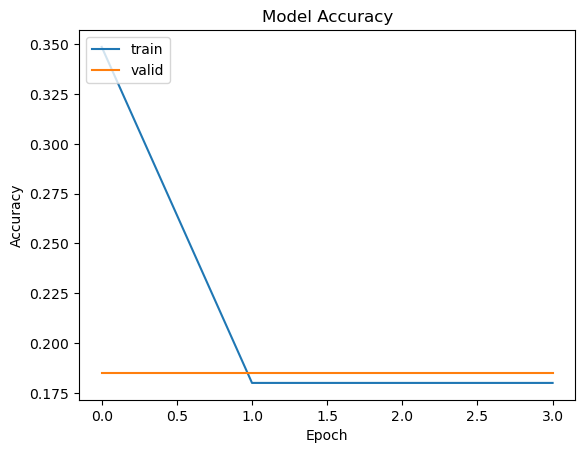

In [96]:
# summarize history for accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

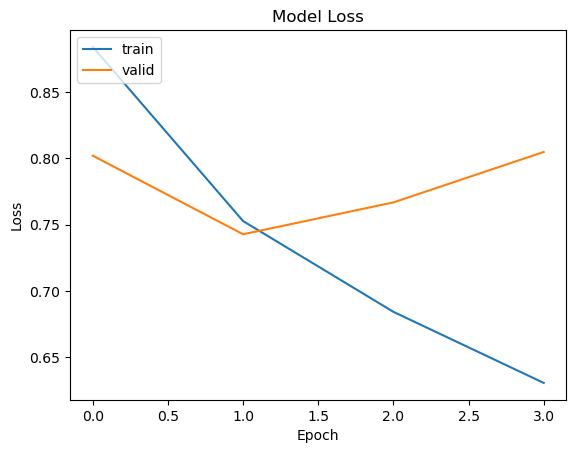

In [97]:
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

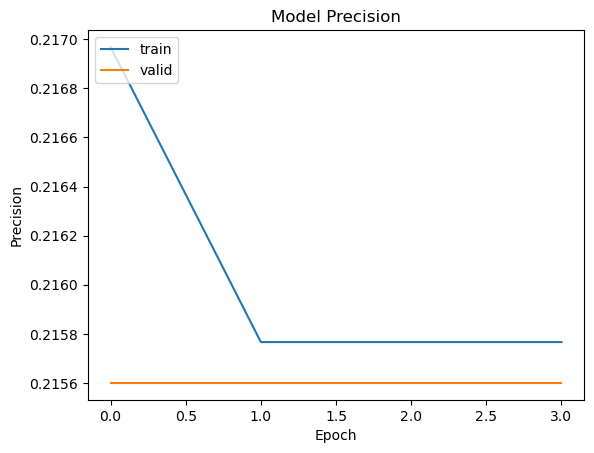

In [98]:
# summarize history for precision
plt.plot(history_3.history['precision'])
plt.plot(history_3.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [99]:
pred_labels_3 = model_3.predict([test_input_ids, test_attention_masks, test_token_type_ids])

110/110 [==============================] - 7s 51ms/step


In [100]:
pred_labels_3[:5]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [101]:
model_3.evaluate([test_input_ids, test_attention_masks, test_token_type_ids], test_labels)

110/110 [==============================] - 7s 65ms/step - loss: 0.8032 - accuracy: 0.1875 - precision: 0.2134


[0.8031780123710632, 0.1875, 0.2133522778749466]

In [102]:
pred_labels_3 = [list(map(prob,i)) for i in pred_labels_3]

In [103]:
pred_labels_3[:5]

[[1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1]]

In [104]:
from sklearn.metrics import label_ranking_average_precision_score
lrap = label_ranking_average_precision_score(pred_labels_3, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  1.0


In [105]:
from sklearn.metrics import classification_report
target_names = train_data_new.columns[1:]
print(classification_report(test_labels, pred_labels_3, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.19      1.00      0.32       660
        fear       0.03      1.00      0.05        91
         joy       0.57      1.00      0.73      2022
     sadness       0.10      1.00      0.18       358
    surprise       0.18      1.00      0.30       624

   micro avg       0.21      1.00      0.35      3755
   macro avg       0.21      1.00      0.32      3755
weighted avg       0.38      1.00      0.52      3755
 samples avg       0.21      1.00      0.35      3755

